In [1]:
import pandas as pd

import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    cost = 0

    x = dataset['x'].to_numpy()
    y = dataset['y'].to_numpy()

    for i in range(len(x) - 1):
        cost += euclidean_distance({'x': x[i], 'y': y[i]}, {'x': x[i+1], 'y': y[i+1]})

    cost += euclidean_distance({'x': x[-1], 'y': y[-1]}, {'x': x[0], 'y': y[0]})

    cost += dataset['cost'].sum()

    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    num_nodes = len(dataset)

    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float64)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                node1 = dataset.iloc[i]
                node2 = dataset.iloc[j]
                distance = euclidean_distance(node1, node2)

                if np.isinf(distance) or np.isnan(distance):
                    raise ValueError(f"Invalid distance encountered between nodes {i} and {j}")

                cost = nodes_cost(node1, node2)
                distance_matrix[i, j] = distance + cost

    return distance_matrix

In [9]:
distance_matrices = []

for dataset in [dataset_A, dataset_B]:
    distance_matrices.append(calculate_distance_matrix(dataset))

In [10]:
print(f'objective function of node1 and node2 = {distance_matrices[1][177, 43]}')

objective function of node1 and node2 = 1797.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution=None):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    if isinstance(solution, pd.DataFrame):
        x = solution['x'].to_numpy()
        y = solution['y'].to_numpy()

        for i in range(len(x) - 1):
            plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color='b', linestyle='-')

        plt.plot([x[-1], x[0]], [y[-1], y[0]], color='b', linestyle='-')

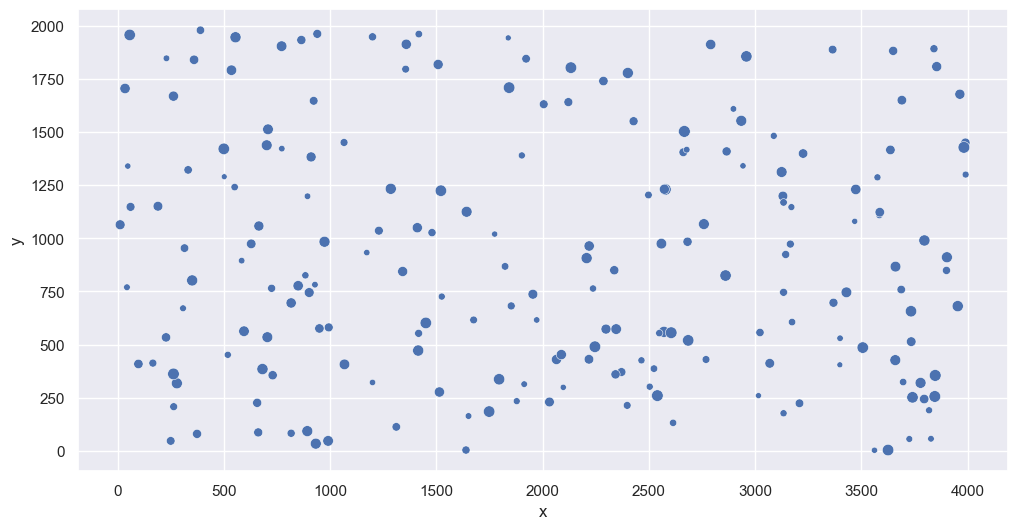

In [12]:
plot(dataset_A)
plt.show()

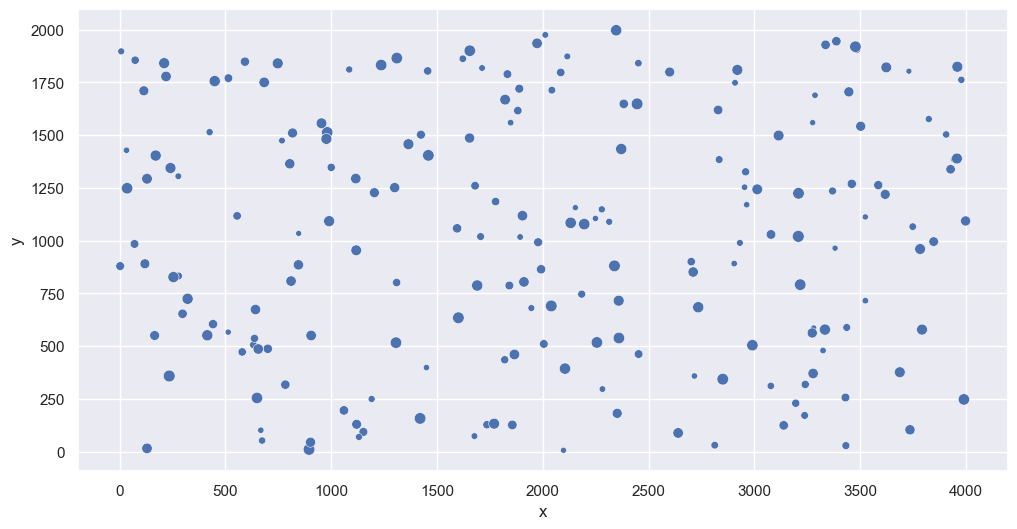

In [13]:
plot(dataset_B)
plt.show()

# Greedy 2-regret heuristic



In [14]:
def tsp_greedy_regret(dataset, distance_matrix, starting_node=0):
    size = int(len(dataset) * 0.5 + 0.5)  # Target size for the cycle
    num_nodes = len(dataset)  # Total number of nodes

    # Make a copy of the distance matrix to avoid modifying the original
    distance_matrix = distance_matrix.copy()

    # Initialize the solution with the starting node
    remaining_nodes = set(range(num_nodes))
    remaining_nodes.remove(starting_node)
    solution = [starting_node]

    # Add the nearest neighbor to the starting node
    nearest_node = np.argmin(distance_matrix[starting_node, list(remaining_nodes)])
    nearest_node_idx = list(remaining_nodes)[nearest_node]
    solution.append(nearest_node_idx)
    remaining_nodes.remove(nearest_node_idx)

    # While the cycle has fewer nodes than the target size
    while len(solution) < size:
        best_2_regret_value = -float('inf')
        best_insertion = None
        best_insertion_cost = None

        # For each remaining node, calculate insertion costs and 2-regret
        for node_idx in remaining_nodes:
            insertion_costs = []

            # Calculate insertion costs for this node at each position in the cycle
            for i in range(len(solution)):
                next_i = (i + 1) % len(solution)

                # Calculate cost of inserting node_idx between solution[i] and solution[next_i]
                current_cost = (
                    distance_matrix[solution[i], node_idx] +
                    distance_matrix[node_idx, solution[next_i]] -
                    distance_matrix[solution[i], solution[next_i]]
                )
                insertion_costs.append((current_cost, i))

            # Sort insertion costs to find the best and second-best
            insertion_costs.sort()
            best_cost, best_position = insertion_costs[0]
            second_best_cost = insertion_costs[1][0] if len(insertion_costs) > 1 else float('inf')

            # Calculate the 2-regret value (difference between best and second-best)
            regret_2_value = best_cost - second_best_cost

            # Update best insertion if this node has the highest regret
            if regret_2_value > best_2_regret_value:
                best_2_regret_value = regret_2_value
                best_insertion = (node_idx, best_position)
                best_insertion_cost = best_cost

        # Insert the node with the highest regret at the position with the lowest cost
        solution.insert(best_insertion[1] + 1, best_insertion[0])
        remaining_nodes.remove(best_insertion[0])

    return dataset.loc[solution]

[124, 122, 63, 182, 136, 53, 158, 70, 173, 180, 80, 133, 151, 162, 161, 59, 131, 47, 65, 116, 77, 42, 43, 28, 35, 127, 29, 11, 54, 30, 48, 160, 34, 103, 195, 192, 181, 193, 142, 199, 134, 18, 163, 22, 159, 41, 96, 5, 197, 118, 109, 51, 176, 66, 115, 36, 117, 0, 170, 143, 62, 9, 111, 12, 94, 100, 26, 150, 75, 101, 97, 152, 74, 120, 25, 16, 88, 40, 119, 71, 58, 164, 39, 165, 14, 144, 155, 3, 178, 55, 52, 8, 185, 91, 145, 78, 44, 57, 128, 167]
Objective function = 111267
################################

Min: 111267
Average: 125414.12
Max: 137230


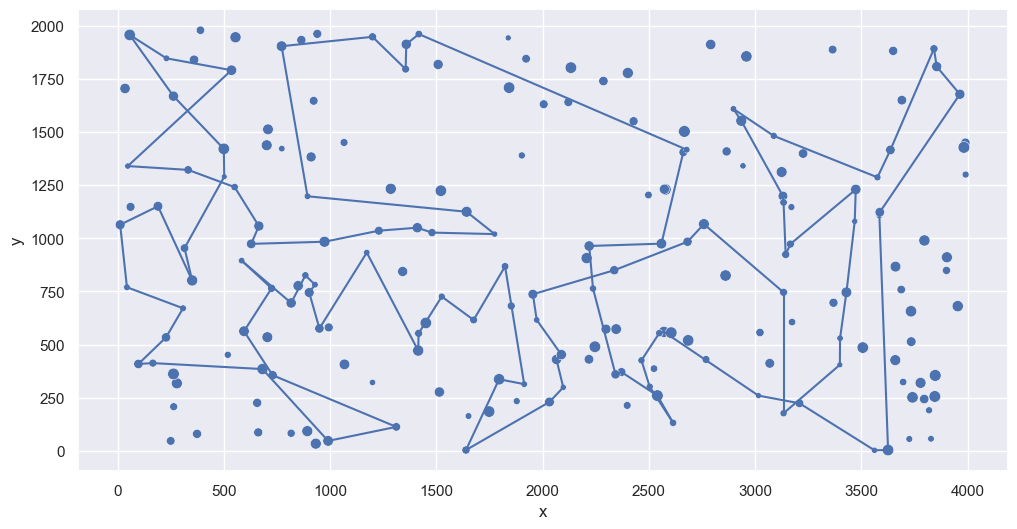

[83, 62, 110, 140, 4, 149, 130, 99, 22, 23, 60, 47, 172, 52, 179, 185, 86, 127, 89, 165, 12, 39, 29, 145, 15, 3, 195, 168, 126, 13, 132, 169, 65, 188, 43, 150, 192, 134, 121, 125, 191, 90, 120, 67, 71, 147, 115, 178, 10, 38, 193, 54, 31, 164, 73, 151, 19, 112, 177, 171, 144, 160, 33, 11, 139, 138, 182, 25, 123, 5, 45, 190, 80, 108, 136, 142, 175, 78, 61, 36, 79, 21, 77, 146, 187, 153, 14, 50, 41, 111, 8, 68, 0, 109, 35, 84, 155, 170, 55, 18]
Objective function = 70451
################################

Min: 70451
Average: 76965.465
Max: 83721


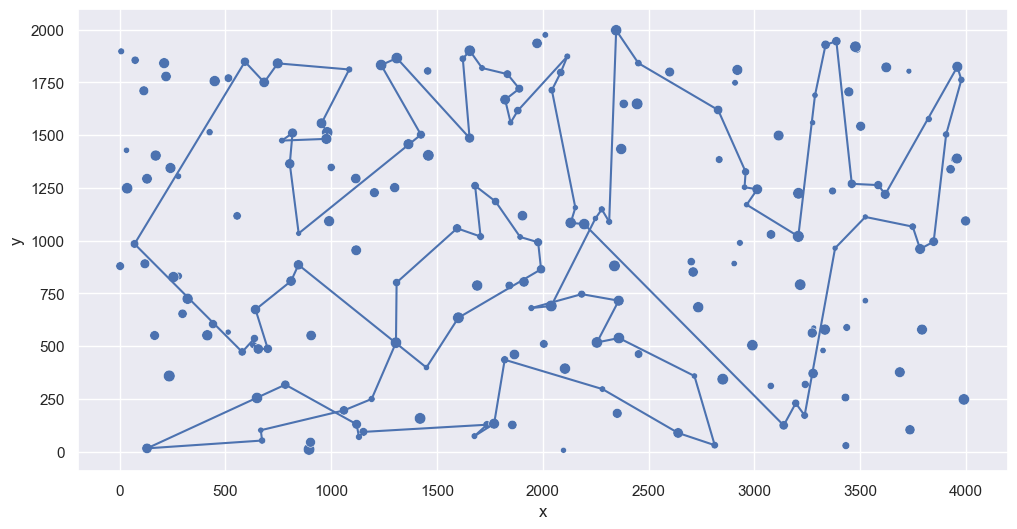

In [15]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        regret_solution = tsp_greedy_regret(dataset, distance_matrices[distance_matrix], idx)
        # print(f"Solution {idx}")

        solution = list(regret_solution.index)

        rating.append((solution, calculate_function_cost(regret_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")

    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset, solution=dataset.loc[best_solution[0]])
    plt.show()

# Greedy Weighted Sum Criterion

In [43]:
def tsp_greedy_weighted_sum(dataset, distance_matrix, starting_node=0, alpha=0.8, beta=0.8):
    distance_matrix = np.asarray(distance_matrix)
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)
    
    # Initialize solution as dynamic list for more flexible handling
    solution = [starting_node]
    remaining_mask = np.ones(num_nodes, dtype=bool)
    remaining_mask[starting_node] = False
    
    # Find nearest neighbor to starting node using vectorized operation
    distances_to_start = distance_matrix[starting_node].copy()
    distances_to_start[~remaining_mask] = np.inf
    nearest_node = np.argmin(distances_to_start)
    solution.append(nearest_node)
    remaining_mask[nearest_node] = False
    
    while len(solution) < size:
        remaining_indices = np.where(remaining_mask)[0]
        if len(remaining_indices) == 0:
            break
            
        current_size = len(solution)
        num_remaining = len(remaining_indices)
        
        # Pre-allocate arrays for vectorized operations
        all_insertion_costs = np.zeros((num_remaining, current_size))
        
        # Vectorized calculation of insertion costs
        for i in range(current_size):
            next_i = (i + 1) % current_size
            current_edges = distance_matrix[solution[i], remaining_indices]
            next_edges = distance_matrix[remaining_indices, solution[next_i]]
            removed_edges = distance_matrix[solution[i], solution[next_i]]
            all_insertion_costs[:, i] = current_edges + next_edges - removed_edges
        
        # Find best and second-best insertion positions for each remaining node
        best_costs = np.min(all_insertion_costs, axis=1)
        best_positions = np.argmin(all_insertion_costs, axis=1)
        
        # Mask the best positions to find second-best
        masked_costs = all_insertion_costs.copy()
        masked_costs[np.arange(num_remaining), best_positions] = np.inf
        second_best_costs = np.min(masked_costs, axis=1)
        
        # Calculate weighted regret values
        weighted_regret_values = alpha * best_costs - beta * second_best_costs
        
        # Find the node with highest weighted regret
        best_node_idx = np.argmax(weighted_regret_values)
        best_node = remaining_indices[best_node_idx]
        best_position = best_positions[best_node_idx]
        
        # Insert the selected node at the correct position
        solution.insert(best_position + 1, best_node)
        remaining_mask[best_node] = False
    
    # Convert solution list to numpy array for final output
    solution = np.array(solution, dtype=np.int32)
    
    # Return the selected nodes as a DataFrame
    return dataset.iloc[solution]

[124, 63, 182, 136, 53, 158, 70, 80, 133, 151, 162, 161, 59, 131, 47, 42, 43, 28, 35, 127, 29, 11, 54, 30, 48, 160, 34, 103, 195, 192, 181, 193, 142, 199, 134, 18, 163, 22, 159, 41, 96, 5, 197, 118, 109, 51, 176, 66, 115, 36, 117, 143, 170, 0, 61, 9, 62, 14, 138, 39, 7, 95, 71, 164, 58, 90, 17, 196, 169, 185, 40, 119, 165, 106, 178, 3, 32, 49, 52, 55, 167, 111, 33, 37, 12, 94, 100, 26, 2, 120, 25, 16, 88, 91, 179, 145, 78, 44, 92, 87]
Objective function = 114627
################################

Min: 114627
Average: 125469.4
Max: 137230


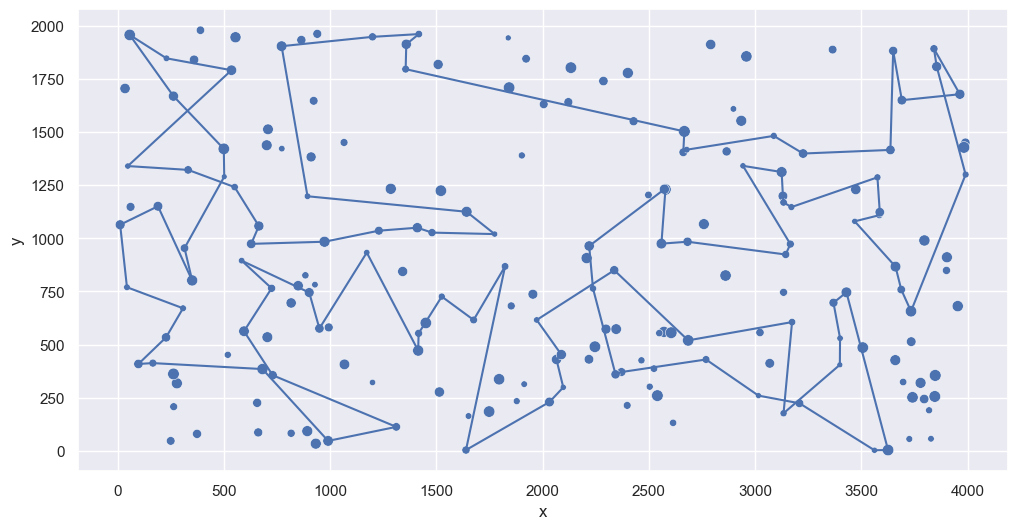

[99, 130, 128, 83, 55, 34, 18, 62, 124, 35, 109, 29, 167, 189, 155, 145, 15, 3, 70, 161, 169, 188, 65, 132, 13, 33, 138, 11, 139, 182, 98, 51, 121, 125, 134, 150, 192, 147, 10, 178, 191, 90, 17, 72, 107, 40, 38, 27, 157, 171, 21, 87, 79, 61, 7, 78, 162, 36, 91, 141, 160, 39, 0, 69, 184, 4, 149, 101, 28, 140, 199, 183, 22, 185, 64, 176, 180, 194, 166, 48, 113, 26, 103, 89, 165, 187, 153, 127, 114, 137, 75, 76, 66, 94, 154, 47, 60, 23, 59, 9]
Objective function = 69934
################################

Min: 69934
Average: 76922.285
Max: 83163


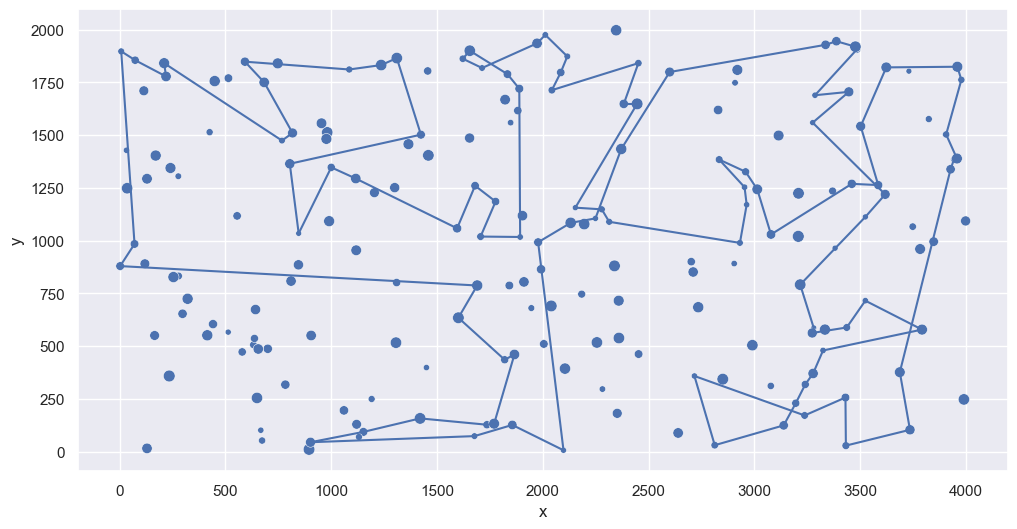

In [44]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        weighted_sum_solution = tsp_greedy_weighted_sum(dataset, distance_matrices[distance_matrix], idx)
        # print(f'Soltuion #{idx} complete')

        solution = list(weighted_sum_solution.index)

        rating.append((solution, calculate_function_cost(weighted_sum_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")

    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset, solution=dataset.loc[best_solution[0]])
    plt.show()

[86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 119, 90, 27, 165, 185, 106, 178, 14, 144, 62, 9, 15, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 117, 0, 68, 46, 118, 59, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 181, 34, 160, 48, 54, 30, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 131, 149, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26]
Objective function = 71069
################################

Min: 71069
Average: 71930.775
Max: 73319


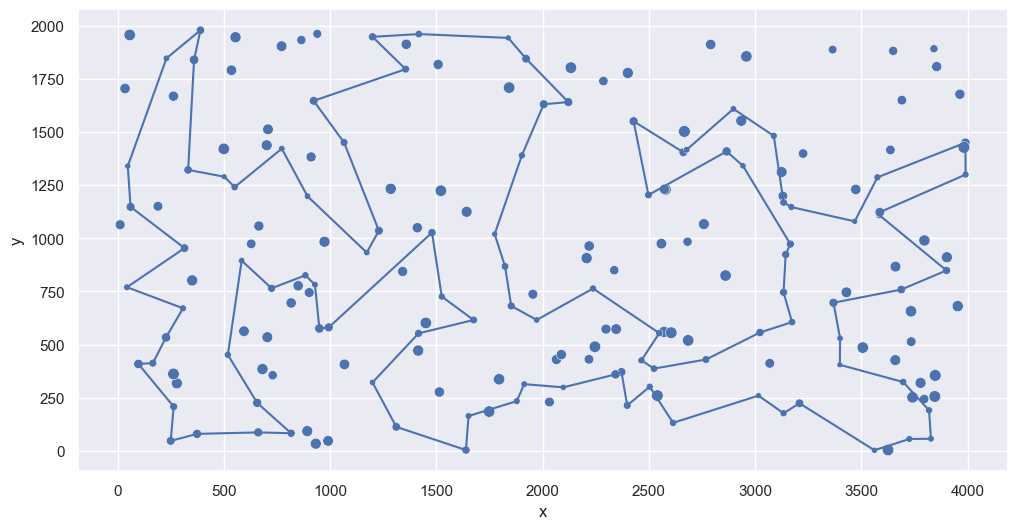

[134, 51, 121, 131, 1, 27, 38, 135, 63, 40, 107, 10, 133, 122, 90, 147, 6, 188, 169, 132, 70, 3, 155, 170, 152, 140, 183, 95, 130, 99, 28, 20, 60, 148, 47, 94, 66, 179, 185, 86, 166, 194, 113, 176, 103, 114, 137, 127, 89, 163, 165, 187, 153, 143, 106, 124, 62, 18, 55, 34, 15, 145, 13, 195, 168, 109, 35, 0, 29, 111, 81, 77, 141, 61, 36, 175, 78, 80, 190, 193, 198, 117, 54, 31, 73, 136, 45, 5, 177, 21, 82, 8, 104, 144, 160, 33, 138, 182, 11, 139]
Objective function = 46806
################################

Min: 46806
Average: 48633.72
Max: 50179


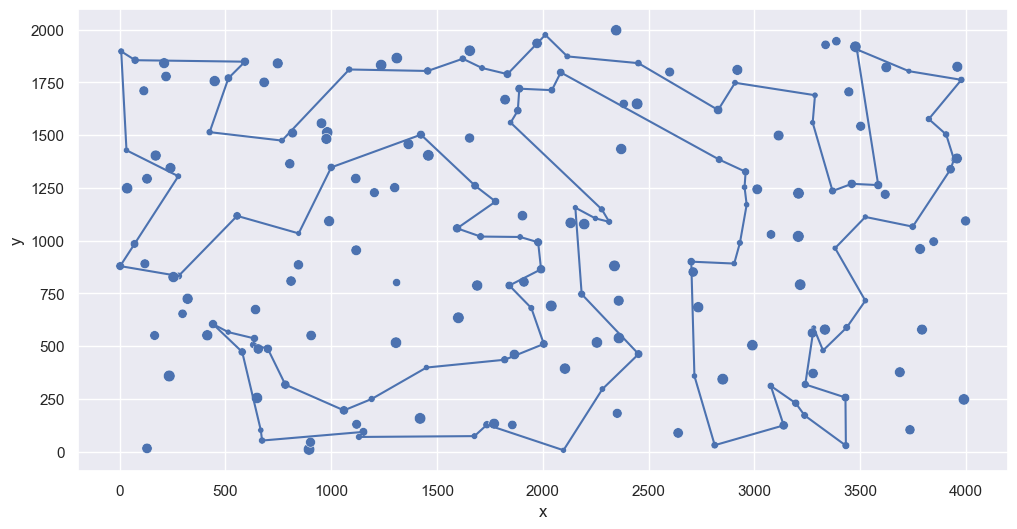

In [45]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        weighted_sum_solution = tsp_greedy_weighted_sum(dataset, distance_matrices[distance_matrix], idx, alpha=0.1, beta=1.0)
        # print(f'Soltuion #{idx} complete')

        solution = list(weighted_sum_solution.index)

        rating.append((solution, calculate_function_cost(weighted_sum_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")

    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset, solution=dataset.loc[best_solution[0]])
    plt.show()